# Latent space analysis - right hemisphere

In [4]:
# Imports
import torch
import pandas as pd
#from preprocessing import create_aims_set
from vae import *
from sklearn.metrics import classification_report
import datasets

In [5]:
side='R'
data_dir = '/neurospin/dico/data/deep_folding/current/crops/CINGULATE/mask/sulcus_based/2mm/'

## Loading of the model

In [8]:
root_dir ='/neurospin/dico/lguillon/midl_22/'
model = VAE((1, 12, 48, 48), 125, depth=3)
model.load_state_dict(torch.load(root_dir + 'checkpoint.pt'))

<All keys matched successfully>

## Analysis

### Loading of test data

In [71]:
# fetch data 
test_csv = '/neurospin/dico/data/deep_folding/current/test.csv'
test_list = pd.read_csv(test_csv, header=None, usecols=[0], names=['subjects'])
test_list['subjects'] = test_list['subjects'].astype('str')

# encode data
tmp = pd.read_pickle(os.path.join(data_dir, f"{side}skeleton.pkl")).T
#tmp = tmp.rename(columns={0:'subjects'})
tmp.index.astype('str')

tmp = tmp.merge(test_list, left_on = tmp.index, right_on='subjects', how='right')
#tmp.merge(test_list, left_on = tmp.index, right_on='subjects', how='right')
filenames = list(test_list.subjects)
test_set = datasets.SkeletonDataset(dataframe=tmp, filenames=filenames)

In [62]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1,
                                          shuffle=True, num_workers=0)

dico_set_loaders = {'test': test_loader}

In [73]:
device = torch.device("cuda", index=0)
model = model.to(device)

class_weights = torch.FloatTensor([1, 7]).to(device)
distance = nn.CrossEntropyLoss(weight=class_weights, reduction='sum')

# HCP -------- dataset_test_loader & benchmark
tester = ModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=distance, kl_weight=2, n_latent=125,
                     depth=3, skeleton=True, root_dir=root_dir)

results = tester.test()

losses = {loader_name:[results[loader_name][k][0] for k in results[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
encoded = {loader_name:[results[loader_name][k][3] for k in results[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

In [74]:
df_encoded = pd.DataFrame()

df_encoded['latent'] = encoded['test']

X = np.array(list(df_encoded['latent']))

In [128]:
results['test']

{('348545',): (4961.9443359375,
  tensor([[[[0, 0, 0,  ..., 0, 0, 0],
            [0, 0, 0,  ..., 0, 0, 0],
            [0, 0, 0,  ..., 0, 0, 0],
            ...,
            [0, 0, 0,  ..., 0, 0, 0],
            [0, 0, 0,  ..., 0, 0, 0],
            [0, 0, 0,  ..., 0, 0, 0]],
  
           [[0, 0, 0,  ..., 0, 0, 0],
            [0, 0, 0,  ..., 0, 0, 0],
            [0, 0, 0,  ..., 0, 0, 0],
            ...,
            [0, 0, 0,  ..., 0, 0, 0],
            [0, 0, 0,  ..., 0, 0, 0],
            [0, 0, 0,  ..., 0, 0, 0]],
  
           [[0, 0, 0,  ..., 0, 0, 0],
            [0, 0, 0,  ..., 0, 0, 0],
            [0, 0, 0,  ..., 0, 0, 0],
            ...,
            [0, 0, 0,  ..., 0, 0, 0],
            [0, 0, 0,  ..., 0, 0, 0],
            [0, 0, 0,  ..., 0, 0, 0]],
  
           ...,
  
           [[0, 0, 0,  ..., 0, 0, 0],
            [0, 0, 0,  ..., 0, 0, 0],
            [0, 0, 0,  ..., 0, 0, 0],
            ...,
            [0, 0, 0,  ..., 0, 0, 0],
            [0, 0, 0,  ..., 0, 0,

In [127]:
encoded

{'test': [array([ 1.333149  ,  0.8524707 ,  1.1936404 ,  0.9028685 ,  1.1985306 ,
         -1.2299423 ,  0.16635075, -0.5440746 ,  1.3471955 , -1.5006258 ,
          0.49903494,  0.27127692, -0.04512501,  0.70801294,  0.23614481,
          0.60389936,  1.5974555 ,  0.07185031,  0.62425363,  0.768636  ,
          0.75430435,  2.0351744 ,  0.01464385,  0.910289  , -0.3627295 ,
          0.3137525 ,  0.8009685 ,  2.3093545 , -0.11494774,  0.29963717,
          0.9531261 , -0.43212968,  0.3009091 ,  0.76376075, -0.9729258 ,
         -1.7117833 ,  1.0648917 ,  2.0268078 , -0.32062984, -0.33356988,
          0.89380395,  1.9481831 ,  0.07865629,  0.16466086,  0.59778243,
          0.74007297, -1.19471   ,  0.7443144 ,  0.31691954, -0.28391248,
         -1.3975642 , -0.5419064 ,  0.70070064,  0.7700964 ,  0.7912297 ,
          0.58387953, -0.28286403, -0.5138257 ,  0.42234537, -0.45020705,
         -0.93628544, -0.7912847 , -1.1404878 , -0.89901125,  0.7222062 ,
         -0.23505232,  0.01454

In [76]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(X)

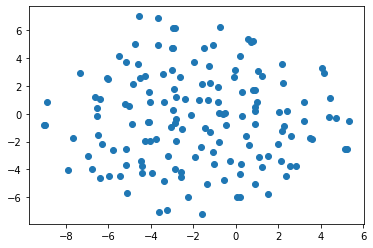

In [84]:
X_embedded = TSNE(n_components=2).fit_transform(X)
color_dict = {'test': 'blue', 'benchmark': 'magenta'}

x = [X_embedded[k][0] for k in range(150)]
y = [X_embedded[k][1] for k in range(150)]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y)
    
plt.show()

In [126]:
# Kmeans
from sklearn.cluster import KMeans
kmeans3d = KMeans(n_clusters=2, random_state=0).fit_predict(X_embedded)
metrics.silhouette_score(X_embedded, kmeans3d)

0.32634613

In [94]:
# Kmeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit_predict(X)

In [95]:
from sklearn import metrics
metrics.silhouette_score(X, kmeans)

0.028188743

In [115]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=10, min_samples=5).fit_predict(X)
#metrics.silhouette_score(X, clustering)

In [116]:
clustering

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [117]:
metrics.silhouette_score(X, clustering)

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)